In [1]:
import tensorflow as tf
from svhn_dataset import SVHN
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [123]:
dataset = [d for d in SVHN().train.shuffle(128).map(SVHN.parse).take(40)]

#transformations: rotation, translation, sheer, zoom
#bbox: (top, left, bottom, right)
bboxes = [d['bboxes'] for d in dataset]
classes = [d['classes'] for d in dataset]
image = [d['image'] for d in dataset]

In [113]:
def draw_image_and_bb(image, bbs):
    #print(f'size: {image.shape}')
    plt.imshow(image)
    ax = plt.gca()
    for bb in bbs:
        ymin, xmin, ymax, xmax = bb.numpy()
        y, x = (ymin + ymax) / 2, (xmin + xmax) / 2
        h, w = (ymax - ymin), (xmax - xmin)
        rect = patches.Rectangle((xmin, ymin),w,h,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [163]:
def augment(img, bbox, width_shift=0, height_shift=0, zoom=0, rotation=0):

    #print(bbox)

    img_height = img.shape[0]
    img_width = img.shape[1]

    idg = tf.keras.preprocessing.image.ImageDataGenerator(
        width_shift_range=width_shift,
        height_shift_range=height_shift,
        zoom_range=zoom,
        rotation_range=rotation,
    )
    transform = idg.get_random_transform(img.shape)

    img_transformed = idg.apply_transform(img.numpy(), transform)

    rot_rad = np.deg2rad(transform['theta'])
    center_tmp = tf.convert_to_tensor([img_height/2, img_width/2, img_height/2, img_width/2], dtype=tf.double)
    centered = tf.cast(bbox, tf.double) - center_tmp
    #print(centered)
    lefttop = tf.stack([centered[:,SVHN.TOP], centered[:,SVHN.LEFT]], axis=1)
    righttop = tf.stack([centered[:,SVHN.TOP], centered[:,SVHN.RIGHT]], axis=1)
    leftbottom = tf.stack([centered[:,SVHN.BOTTOM], centered[:,SVHN.LEFT]], axis=1)
    rightbottom = tf.stack([centered[:,SVHN.BOTTOM], centered[:,SVHN.RIGHT]], axis=1)
    new_top = tf.minimum(
        lefttop[:,1] * np.sin(rot_rad) + lefttop[:,0] * np.cos(rot_rad),
        righttop[:,1] * np.sin(rot_rad) + righttop[:,0] * np.cos(rot_rad)
    )
    new_bottom = tf.maximum(
        leftbottom[:,1] * np.sin(rot_rad) + leftbottom[:,0] * np.cos(rot_rad),
        rightbottom[:,1] * np.sin(rot_rad) + rightbottom[:,0] * np.cos(rot_rad)
    )
    new_left = tf.minimum(
        lefttop[:,1] * np.cos(rot_rad) - lefttop[:,0] * np.sin(rot_rad),
        leftbottom[:,1] * np.cos(rot_rad) - leftbottom[:,0] * np.sin(rot_rad)
    )
    new_right = tf.maximum(
        righttop[:,1] * np.cos(rot_rad) - righttop[:,0] * np.sin(rot_rad),
        rightbottom[:,1] * np.cos(rot_rad) - rightbottom[:,0] * np.sin(rot_rad)
    )
    rotate_box = tf.stack([
        new_top,
        new_left,
        new_bottom,
        new_right,
    ], axis=1)
    #print(rotate_box)

    translate_tmp = tf.convert_to_tensor([-transform['tx'], -transform['ty'], -transform['tx'], -transform['ty']], dtype=tf.double)
    translate_bbox = tf.add(rotate_box, translate_tmp)
    #print(translate_bbox)

    zoom_tmp = tf.convert_to_tensor([transform['zx'], transform['zy'], transform['zx'], transform['zy']], dtype=tf.double)
    #print(translate_bbox / zoom_tmp)
    zoom_bbox = tf.cast(translate_bbox / zoom_tmp + center_tmp, tf.int64)
    #print(zoom_bbox)

    return img_transformed, zoom_bbox

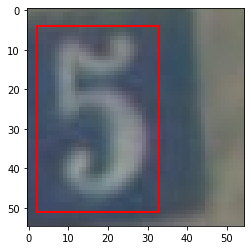

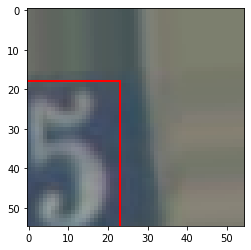

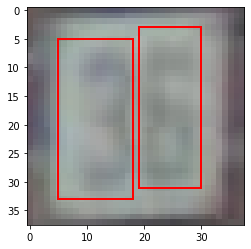

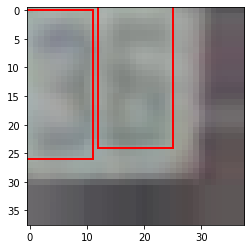

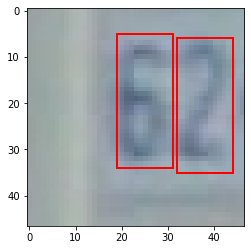

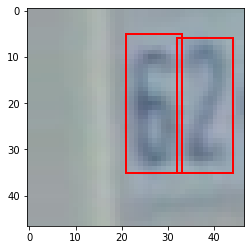

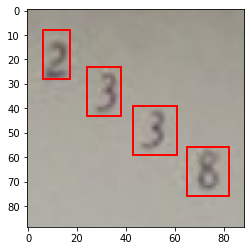

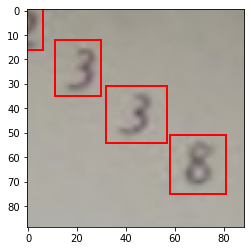

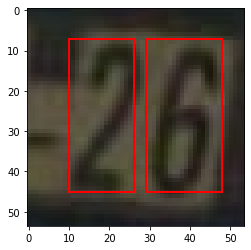

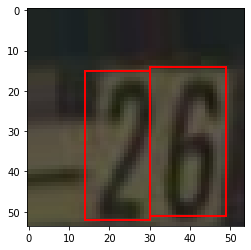

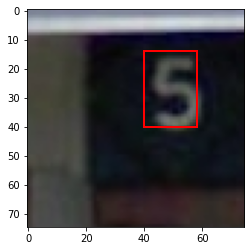

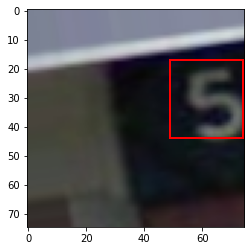

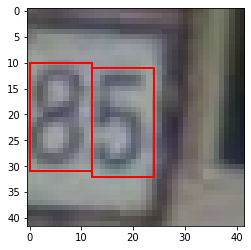

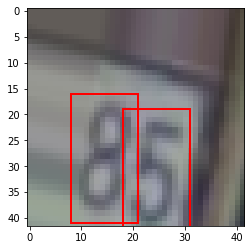

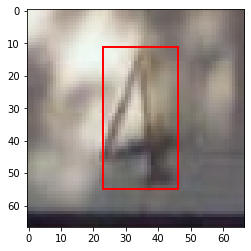

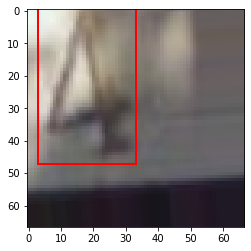

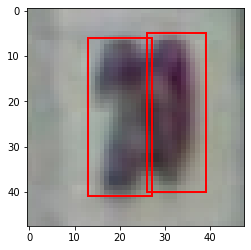

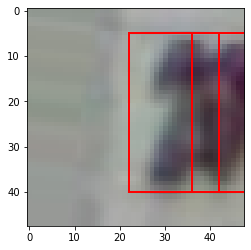

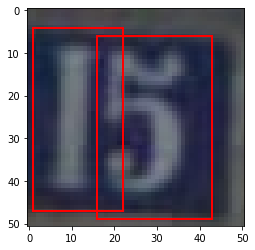

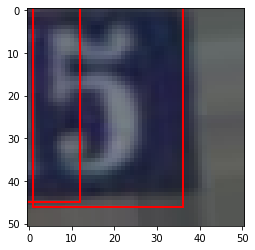

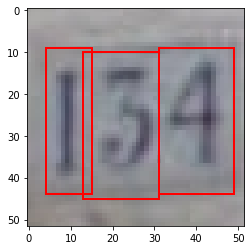

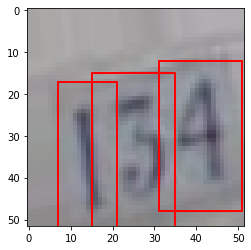

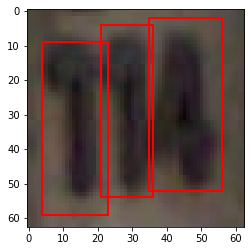

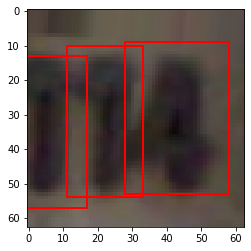

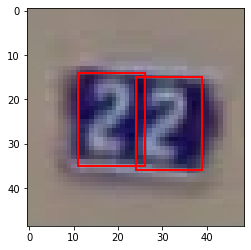

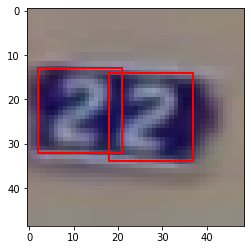

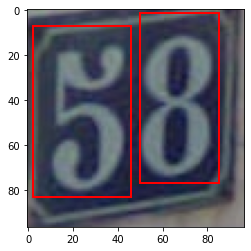

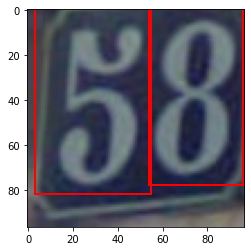

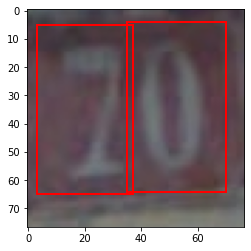

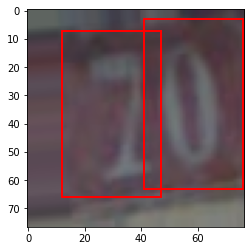

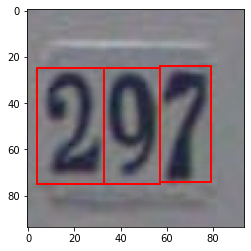

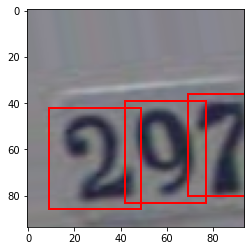

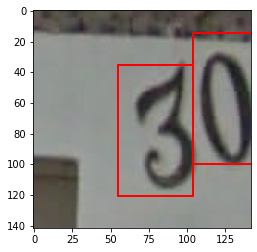

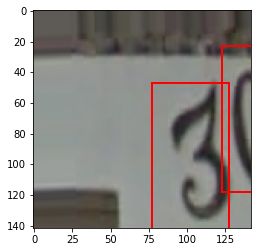

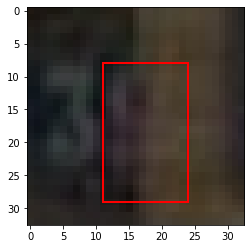

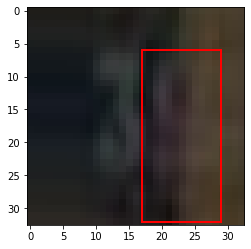

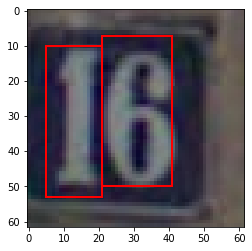

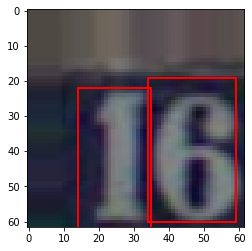

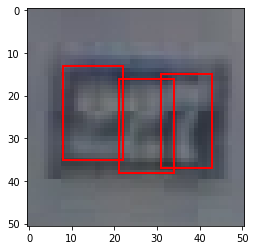

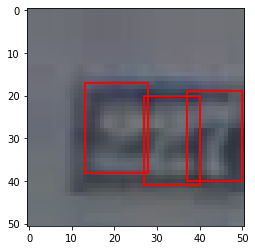

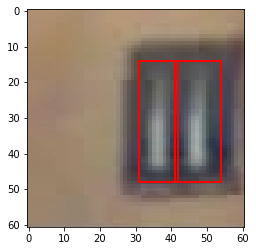

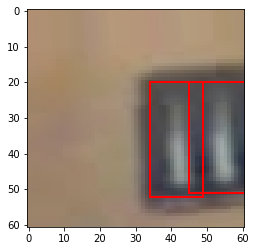

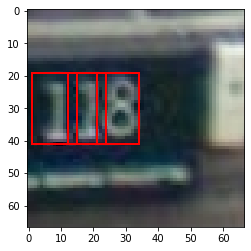

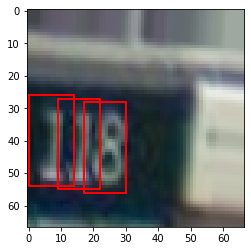

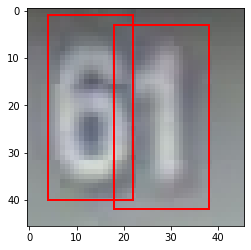

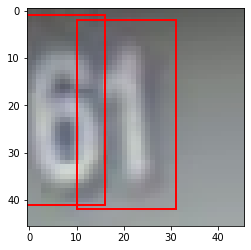

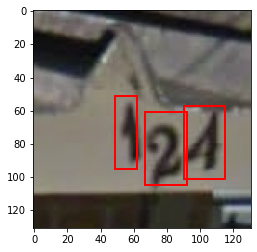

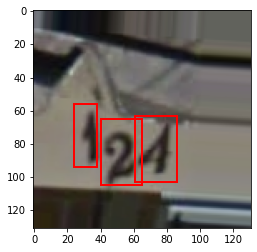

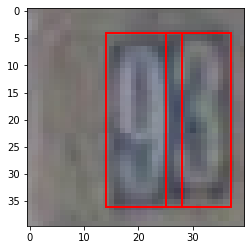

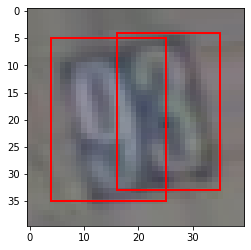

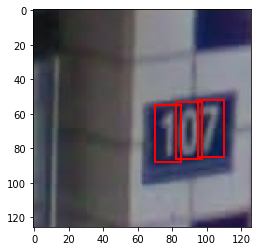

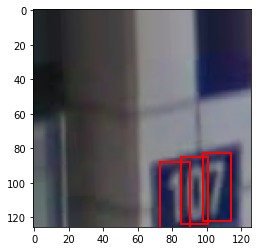

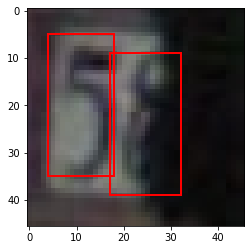

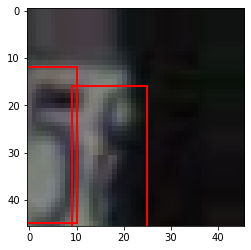

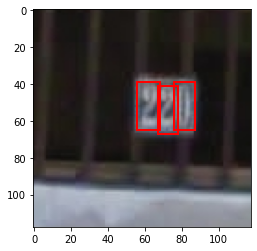

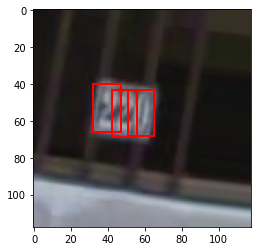

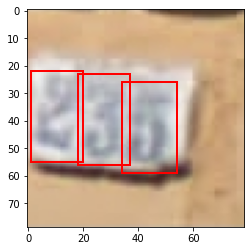

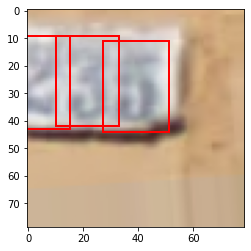

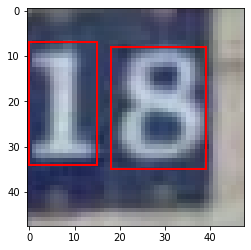

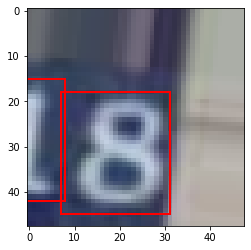

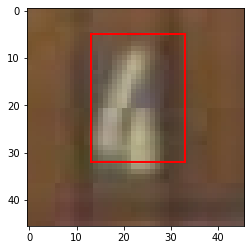

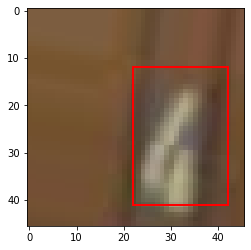

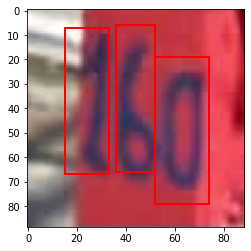

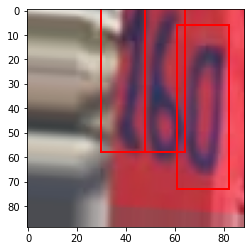

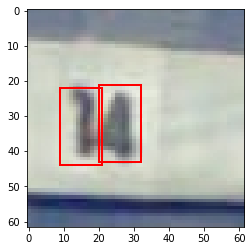

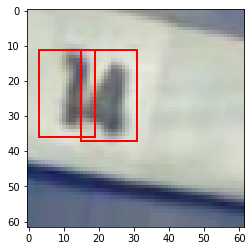

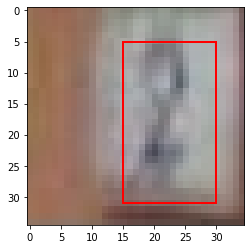

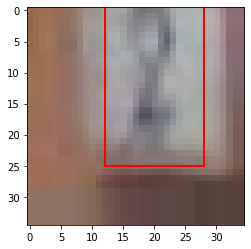

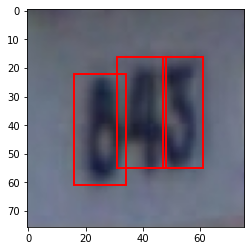

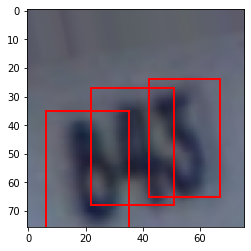

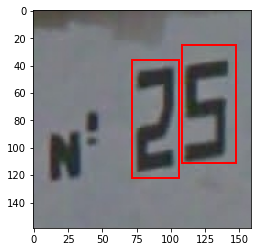

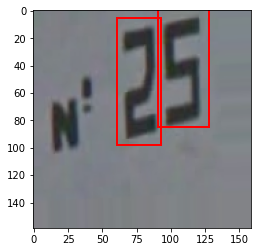

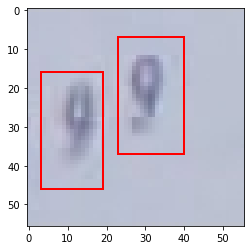

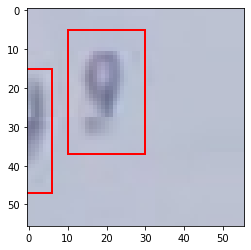

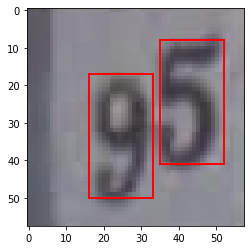

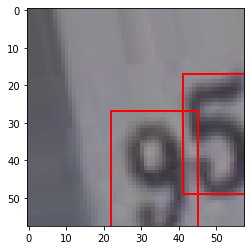

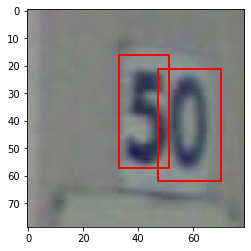

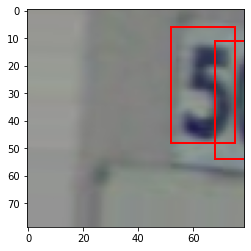

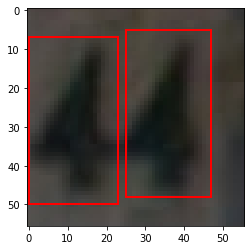

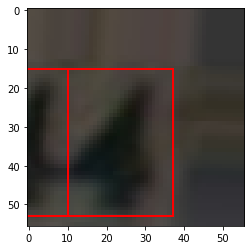

In [165]:
for img, bbox in zip(image, bboxes):
    #print("-----NEXT------")
    draw_image_and_bb(img, bbox)
    tranformed_img, transformed_bbox = augment(img, bbox, width_shift=0.25, height_shift=0.25, zoom=0.2, rotation=10)
    draw_image_and_bb(tranformed_img, transformed_bbox)